### Exploration of subtasks / methodology:

 - ### Caption sentiment class extraction
 - ### Caption sentiment classifier
 - ### Image feature extraction Pipeline: 
     - VGG-16
     - Inception
     - AlexNet
         - According to [google's dataset paper](https://www.aclweb.org/anthology/P18-1238.pdf) Inception_Resnet_v2 is best for feature extraction
 - ### Image object detection/ data
 - ### Object + Sentiment sentence generation
 - ### End to End model from tutorial
 - ### Caption evaluation pipeline:
     - BLEU score
     - Perplexity?
 

## Initial loading and displaying

In [98]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from utils import load_meta_data_from_dir
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [108]:
data_dir = 'initial_sample'


In [109]:

image_captions,images_folder, meta_path = load_meta_data_from_dir(data_dir, 'prepped_meta')

In [110]:
print(meta_path)
#we are using an already preprocessed set so we dont have to process and save again. Set this to true whenever we want
#to re-process and save certain columns
process = False

data\initial_sample\prepped_meta


In [113]:
process=True

In [111]:
len(image_captions)

9296

In [112]:
print(image_captions.columns)

Index(['caption', 'link', 'objects', 'mid', 'object_confidences', 'image_path',
       'global_index', 'size'],
      dtype='object')


In [114]:

#load a few sample images with captions
def display_samples(meta_df, num_samples=5, seed = 0):
    #sample num_sample rows from the dataframe
    samples = meta_df.sample(n=num_samples,random_state = 0)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        #get objects and confidence scores
        objects = row['objects'].split(',')
        confidences = row['object_confidences'].split(',')
        
        obj_conf = [str((obj,conf[0:4])) for obj,conf in zip(objects,confidences)]
        num_obj = len(obj_conf)
        obj_str = "\n".join(obj_conf)
        image = Image.open(file_name)
        fig = plt.figure(figsize=(10,(0.3*num_obj)))
        ax = fig.add_subplot(121)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image) 
        ax.set_title(caption)
        ax = fig.add_subplot(122)
        ax.text(0.1, 0.5, obj_str, horizontalalignment='left',verticalalignment='center')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        







In [115]:
#Add notebook relative file_path to image
if(process):
    image_captions['image_path'] = image_captions['global_index'].apply(lambda p: os.path.join(images_folder, str(p) + ".png"))

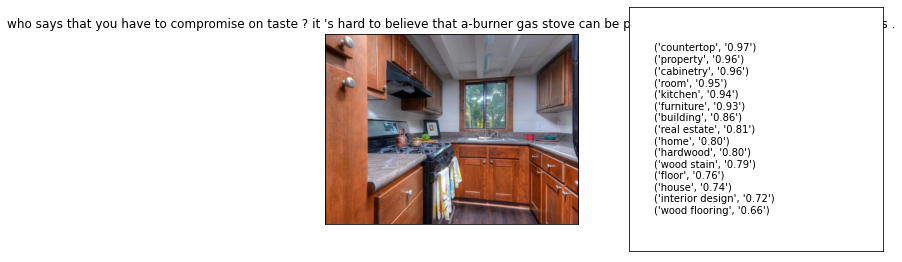

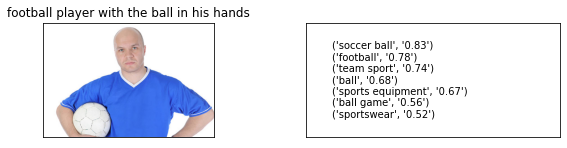

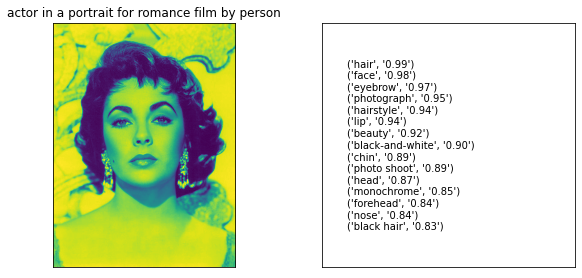

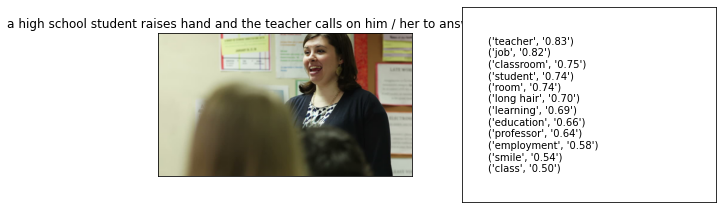

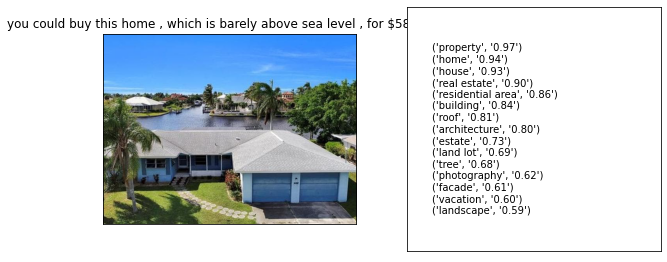

In [116]:
display_samples(image_captions)

## Profiling
- Size distribution of images
- Aspect Ration distribution of images: w/h
- Distribution of number of objects per image
- Distribution of number of objects at various confidence thresholds
- Distribution of caption size for each image

### Size distribution of images
This takes a while to run

In [117]:

if(process):
    image_captions['size'] = image_captions['image_path'].apply(lambda p: Image.open(p).size)
    image_captions
    image_captions.to_csv(os.path.join('data', data_dir,'prepped_meta'), index=False)

In [118]:
#number of different sizes:
image_captions['size'].describe()

count           9296
unique          3476
top       (450, 470)
freq             800
Name: size, dtype: object

In [119]:
#profiling widths and heights

image_captions['height'] = image_captions['size'].apply(lambda x: x[1])
image_captions['width'] = image_captions['size'].apply(lambda x: x[0])

In [120]:
image_captions['height'].describe()


count    9296.000000
mean      665.300237
std       331.351003
min       150.000000
25%       470.000000
50%       600.000000
75%       736.000000
max      5760.000000
Name: height, dtype: float64

In [121]:
image_captions['width'].describe()

count    9296.000000
mean      714.408025
std       364.977336
min       150.000000
25%       470.000000
50%       612.000000
75%       800.000000
max      5184.000000
Name: width, dtype: float64

<AxesSubplot:ylabel='Frequency'>

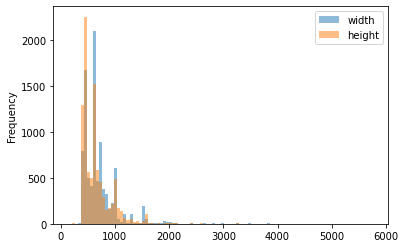

In [123]:
image_captions[['width','height']].plot.hist(bins = 100, alpha=0.5)

In [124]:
#looks like most images have a height and width under 1000 

In [125]:
quant = 0.9
print(image_captions['height'].quantile(quant))
print(image_captions['width'].quantile(quant))

1024.0
1024.0


In [126]:
q = np.linspace(.1, 1, 9, 0)
print(image_captions['height'].quantile(q))
print(image_captions['width'].quantile(q))

0.1     412.0
0.2     450.0
0.3     470.0
0.4     500.0
0.5     600.0
0.6     612.0
0.7     683.0
0.8     803.0
0.9    1024.0
Name: height, dtype: float64
0.1     446.0
0.2     450.0
0.3     508.0
0.4     604.0
0.5     612.0
0.6     672.0
0.7     736.0
0.8     852.0
0.9    1024.0
Name: width, dtype: float64


### Aspect ratio distribution of images

In [127]:
image_captions['aspect_ratio'] = image_captions.apply(lambda x: x.width/x.height , axis=1)

In [128]:
image_captions['aspect_ratio'].describe()

count    9296.000000
mean        1.127480
std         0.356344
min         0.477124
25%         0.779473
50%         1.000000
75%         1.493396
max         2.257143
Name: aspect_ratio, dtype: float64

In [129]:
quant = 0.99
l_quant = 0.01
print(image_captions['aspect_ratio'].quantile(quant))
print(image_captions['aspect_ratio'].quantile(l_quant))
#so 98% of the data is between aspect ratio of 0.6 and 1.78

1.7857142857142858
0.577416927333975


<AxesSubplot:ylabel='Frequency'>

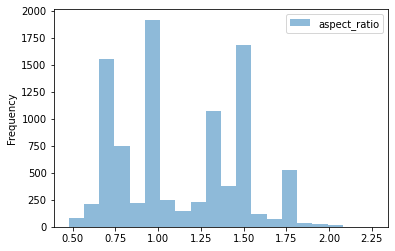

In [130]:
image_captions[['aspect_ratio']].plot.hist(bins=20, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

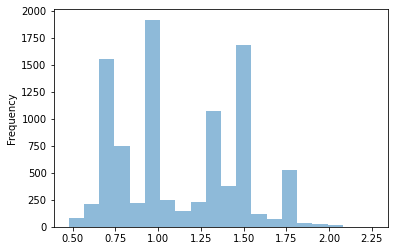

In [131]:
#lets remove ratio above 1000 and try agains (strange outlier)
image_captions[image_captions['aspect_ratio'] <= 1000]['aspect_ratio'].plot.hist(bins=20, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

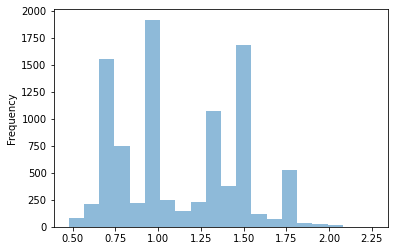

In [132]:
# now lets remove ratios above 3 and try again (most values lie here). All values are above 0.5
image_captions[(image_captions['aspect_ratio'] <= 3) ]['aspect_ratio'].plot.hist(bins=20, alpha=0.5)

### Number of objects per image

In [133]:
image_captions['num_obj'] = image_captions['objects'].apply(lambda o: 0 if pd.isna(o) else len(str(o).split(',')))

In [134]:
image_captions['num_obj'].describe()


count    9296.000000
mean       12.069170
std         3.624264
min         0.000000
25%         9.000000
50%        14.000000
75%        15.000000
max        15.000000
Name: num_obj, dtype: float64

In [135]:
image_captions['num_obj'].value_counts()


15    4488
12     534
11     518
10     499
9      492
13     452
14     447
8      442
7      436
6      346
5      271
4      180
3      122
2       47
1       18
0        4
Name: num_obj, dtype: int64

All but 4 images have atleast 1 object in them and a maximum of 15 objects in them and around 50% of the images have 15 objects detected

<AxesSubplot:ylabel='Frequency'>

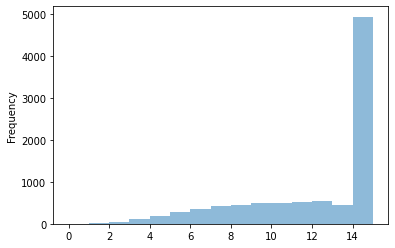

In [136]:
image_captions['num_obj'].plot.hist(bins=15, alpha=0.5)

### Distribution of num_objects at various confidence thresholds


In [137]:
def get_objects_with_conf_above(meta_df, threshold):
    """
    Returns a Series with a list of tuples (object,float) of object and confidence with confidence greater that threshold.
    """

    #object_conf tuple for objects with confidence above threshold
    obj_conf = image_captions.apply(lambda x: [] if (pd.isna(x.objects) or pd.isna(x.object_confidences))
                                   else [(obj,float(conf)) for (obj,conf) in zip(x.objects.split(','), x.object_confidences.split(',')) 
                                        if float(conf) >=threshold], axis=1)
    return obj_conf
    


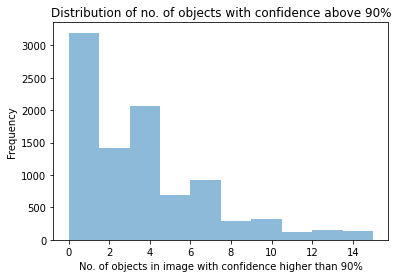

Number of images with atleast 1 caption with confidence higher than 90%: 7721


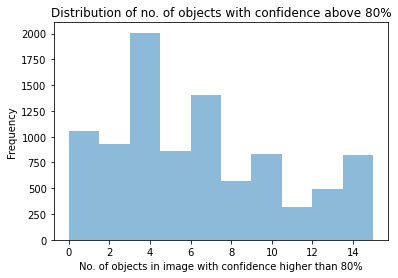

Number of images with atleast 1 caption with confidence higher than 80%: 8911


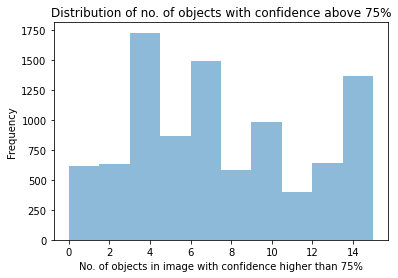

Number of images with atleast 1 caption with confidence higher than 75%: 9099


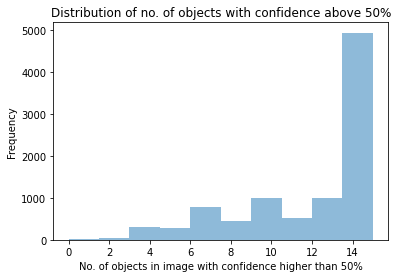

Number of images with atleast 1 caption with confidence higher than 50%: 9292


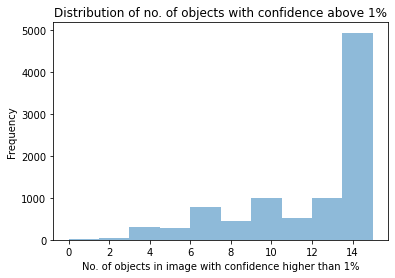

Number of images with atleast 1 caption with confidence higher than 1%: 9292


In [138]:
#get number of objects at various thresholds and plot them
thresholds = [90,80,75,50,1]
for t in thresholds:
    num_obj_conf = get_objects_with_conf_above(image_captions,(t*0.01)).apply(lambda l: len(l))
    num_obj_conf.plot.hist(alpha=0.5,title=f"Distribution of no. of objects with confidence above {t}%").set_xlabel(f"No. of objects in image with confidence higher than {t}%")
    plt.show()
    print(f"Number of images with atleast 1 caption with confidence higher than {t}%:",len(num_obj_conf[num_obj_conf > 0]))   


### Distribution of caption size

In [139]:
caption_size = image_captions['caption'].apply(lambda x: len(x.split(" ")))
caption_size.describe()

count    9296.000000
mean       10.320783
std         4.770961
min         5.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        41.000000
Name: caption, dtype: float64

<AxesSubplot:title={'center':'Distribution of caption size of image captions'}, ylabel='Frequency'>

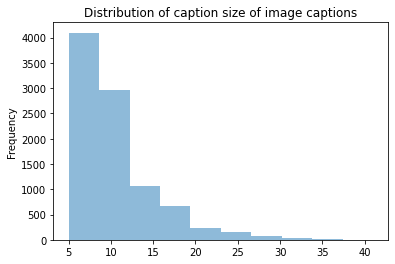

In [140]:
caption_size.plot.hist(alpha=0.5,title="Distribution of caption size of image captions")


In [141]:
caption_size.quantile([0.01,0.1,0.25,0.5,0.7,0.9,0.95, 0.99])


0.01     5.0
0.10     6.0
0.25     7.0
0.50     9.0
0.70    12.0
0.90    17.0
0.95    20.0
0.99    27.0
Name: caption, dtype: float64

All captions are more than 5 words and only 5% are above 20 words

## Divide captions into sentiment classes. 

 - nltk's pretrained SentimentIntensityAnalyser: sentiment and polarity
 - huggingface pretrained classifier

In [142]:
def display_samples_with_hf_label(meta_df, label, conf_thresh=0.9,num_samples=5, seed = 0, sent_class_col = 'hf_sent_class',sent_conf_col = 'hf_sent_conf' ):
    """
    Looking at positive and negative samples
    """
    #setting colors
    if("pos" in label.lower()):
        color = 'green'
    else:
        color = 'red'
    #filter to see high confidence examples of desired labels
    high_conf = meta_df[meta_df[sent_class_col] == label]
    high_conf = high_conf[high_conf[sent_conf_col] >= conf_thresh]
    #sample num_sample rows from the dataframe
    samples = high_conf.sample(n=num_samples,random_state = seed)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        #get objects and confidence scores
        objects = row['objects'].split(',')
        confidences = row['object_confidences'].split(',')
        sent_label_conf_str = (row[sent_class_col],str(row[sent_conf_col]))
        
        obj_conf = [str((obj,conf[0:4])) for obj,conf in zip(objects,confidences)]
        num_obj = len(obj_conf)
        obj_str = "\n".join(obj_conf)
        image = Image.open(file_name)
        fig = plt.figure(figsize=(20,(0.3*num_obj)))
        ax = fig.add_subplot(121)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image) 
        
        ax = fig.add_subplot(122)
        ax.text(0.1, 1, sent_label_conf_str, horizontalalignment='left',verticalalignment='top', fontsize = 11, color = color, bbox=dict(boxstyle = "square", color='white' ))
        
        ax.text(0.1, 0.5, obj_str, horizontalalignment='left',verticalalignment='center')
        plt.suptitle(caption)
        plt.xticks([])
        plt.yticks([])
        plt.show()

### NLTK's pretrained classifer and polarity scores

In [143]:
import nltk


In [144]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

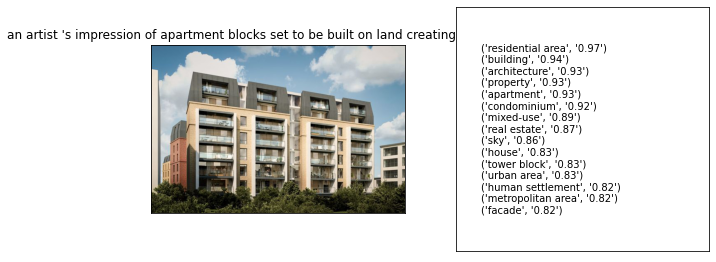

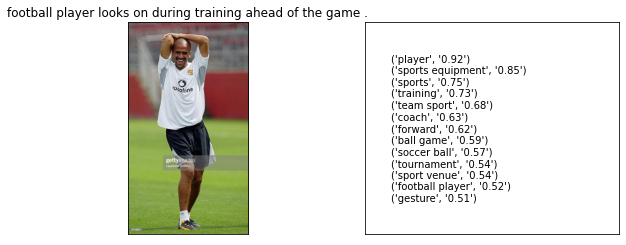

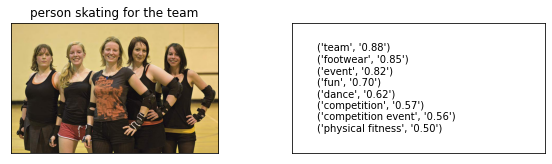

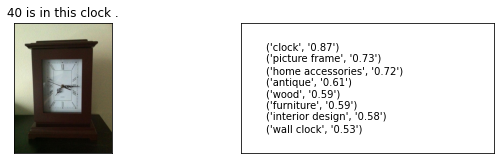

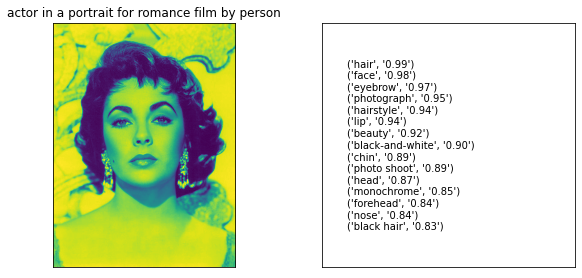

In [145]:
#example on random captions

random_sample = image_captions.sample(n=50, random_state=0)
display_samples(random_sample)

In [146]:
random_sample['nltk_sent_int'] = random_sample['caption'].apply(lambda x: sia.polarity_scores(x))
#classify using polarity scores: class with max polarity
random_sample['nltk_sent'] = random_sample['nltk_sent_int'].apply(lambda x: max(['neu', 'pos','neg'], key=x.get))
random_sample['nltk_sent'].value_counts() 

neu    50
Name: nltk_sent, dtype: int64

In [147]:
#now do this pfor everything and plot histogram of classes
image_captions['nltk_sent_polarity'] = image_captions['caption'].apply(lambda x: sia.polarity_scores(x))

In [148]:
image_captions['nltk_sent'] = image_captions['nltk_sent_polarity'].apply(lambda x: max(['neu', 'pos','neg'], key=x.get))

In [149]:
image_captions['nltk_sent'].describe()

count     9296
unique       3
top        neu
freq      9081
Name: nltk_sent, dtype: object

In [150]:
image_captions['nltk_sent'].value_counts()

neu    9081
pos     188
neg      27
Name: nltk_sent, dtype: int64

<AxesSubplot:>

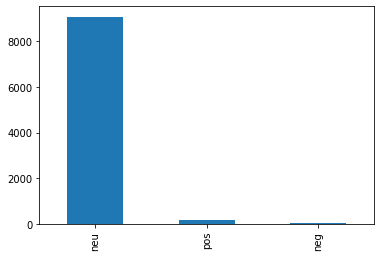

In [151]:
image_captions['nltk_sent'].value_counts().plot(kind='bar')

As we can see (and as expected), the overwhelming majority of captions are neutral

We can try limiting to the sentiment with max polarity among just positive and negative

In [152]:
image_captions['nltk_sent_pos_neg'] = image_captions['nltk_sent_polarity'].apply(lambda x: max(['pos','neg'], key=x.get))

In [153]:
image_captions['nltk_sent_pos_neg'].value_counts()

pos    8511
neg     785
Name: nltk_sent_pos_neg, dtype: int64

<AxesSubplot:>

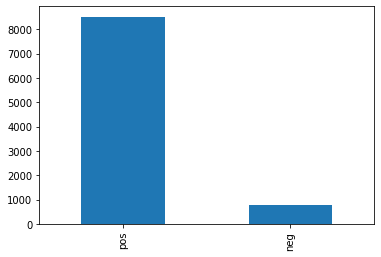

In [154]:
image_captions['nltk_sent_pos_neg'].value_counts().plot(kind='bar')

Still, classes are very unbalanced. 

In [155]:
image_captions['nltk_sent_pos_neg_conf'] = image_captions.apply(lambda x: x['nltk_sent_polarity'][x['nltk_sent_pos_neg']], axis=1)

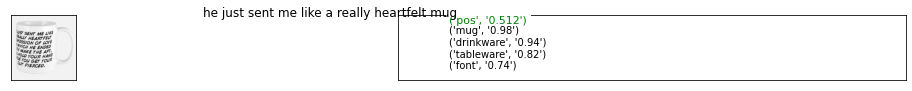

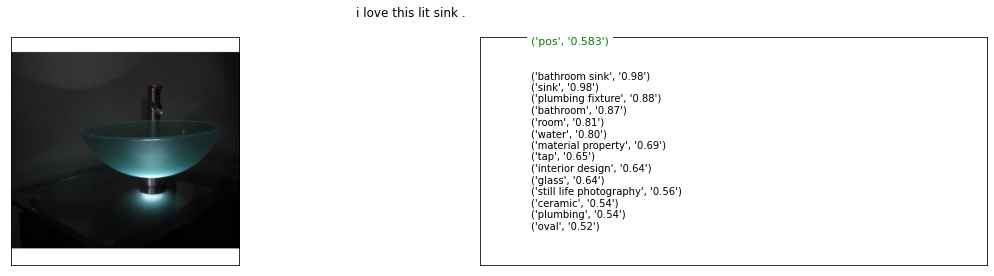

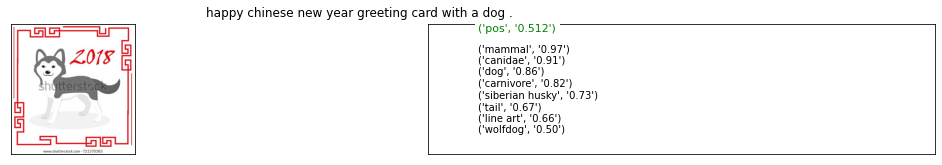

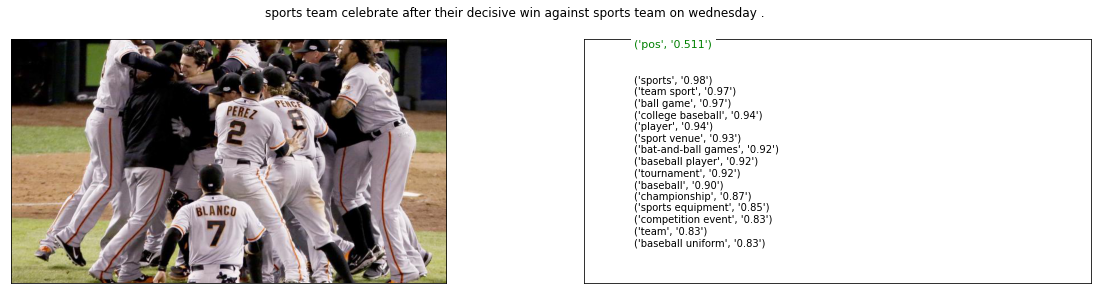

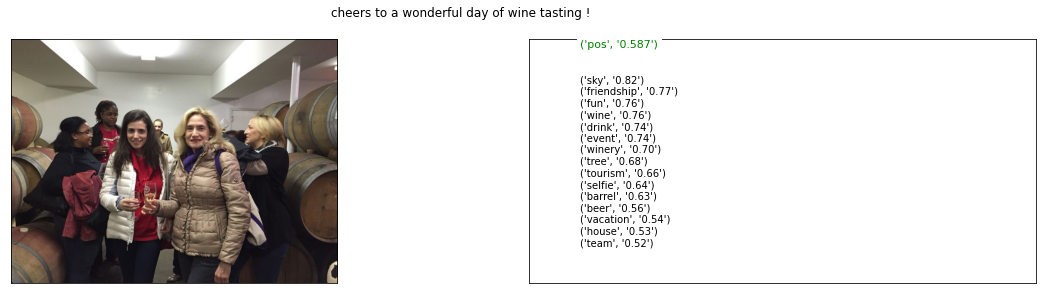

In [156]:
display_samples_with_hf_label(image_captions,'pos',conf_thresh=0.5,sent_class_col='nltk_sent_pos_neg',sent_conf_col='nltk_sent_pos_neg_conf')

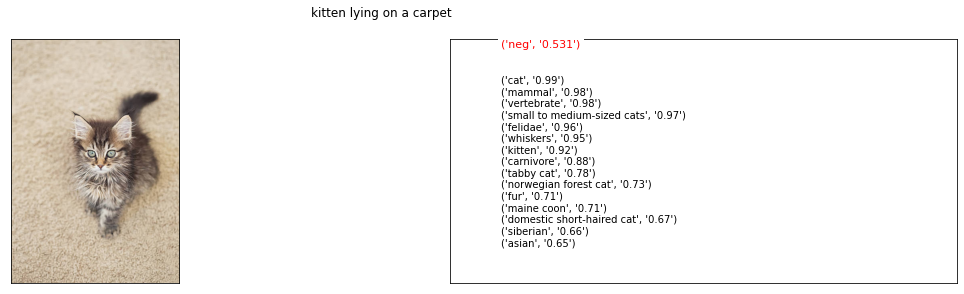

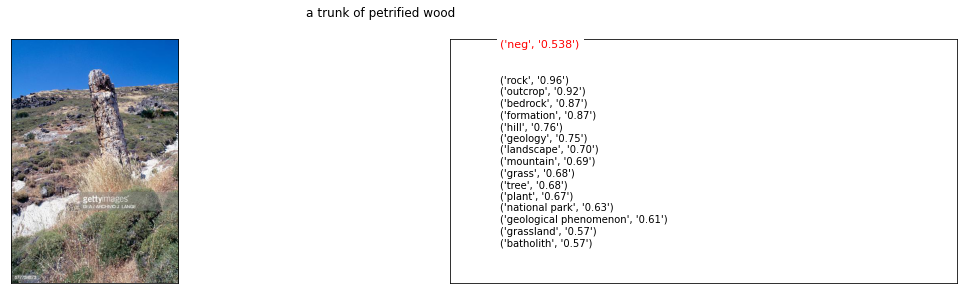

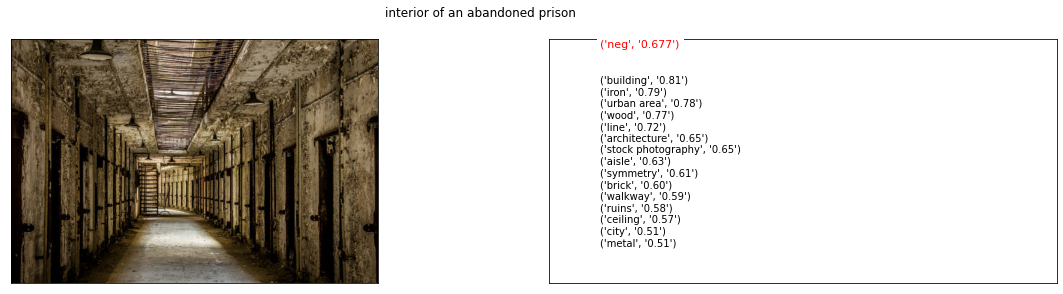

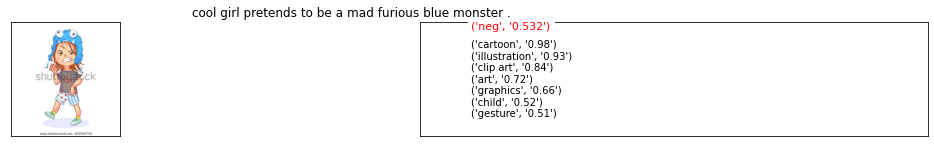

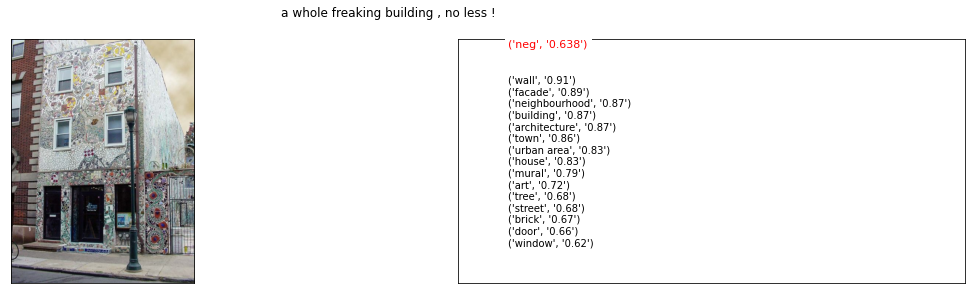

In [157]:
display_samples_with_hf_label(image_captions,'neg',conf_thresh=0.5,sent_class_col='nltk_sent_pos_neg',sent_conf_col='nltk_sent_pos_neg_conf')

### Huggingface's pretrained classifier

In [158]:
from transformers import pipeline


In [159]:
hf_sent = pipeline('sentiment-analysis')


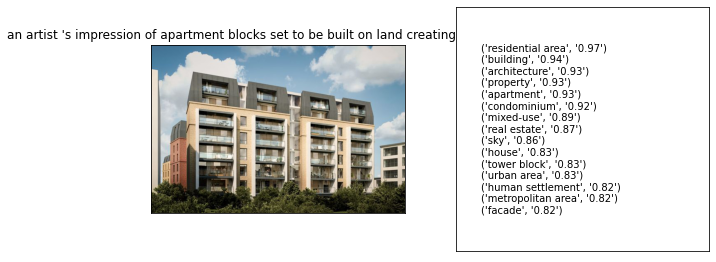

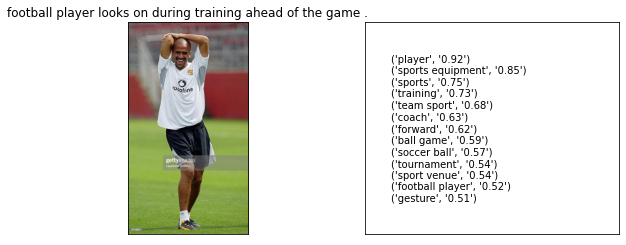

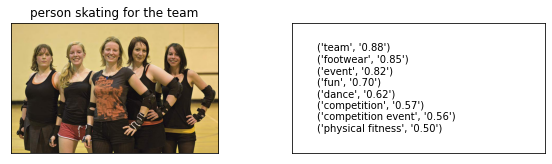

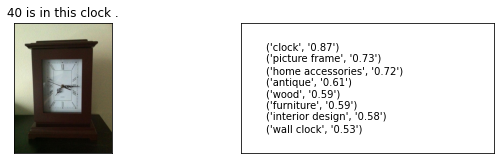

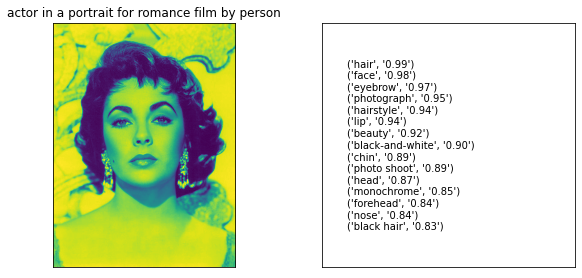

In [160]:
#example on random captions

random_sample = image_captions.sample(n=50, random_state=0)
#display 45 of the random samples
display_samples(random_sample)

In [161]:
random_sample['hf_sent'] = random_sample['caption'].apply(lambda x: hf_sent(x))
random_sample['hf_sent_label'] = random_sample['hf_sent'].apply(lambda x: x[0]['label'])
random_sample['hf_sent_label'].value_counts()
#looks a bit more divided!

POSITIVE    36
NEGATIVE    14
Name: hf_sent_label, dtype: int64

This cell takes a while since we are conducting sentiment analysis on all data.

In [162]:
image_captions['hf_sent'] = image_captions['caption'].apply(lambda x: hf_sent(x))

In [163]:
image_captions['hf_sent_class'] = image_captions['hf_sent'].apply(lambda x: x[0]['label'])
image_captions['hf_sent_conf'] = image_captions['hf_sent'].apply(lambda x: x[0]['score'])

In [164]:
image_captions['hf_sent_class'].describe()

count         9296
unique           2
top       POSITIVE
freq          6401
Name: hf_sent_class, dtype: object

In [165]:
image_captions['hf_sent_class'].value_counts()/sum(image_captions['hf_sent_class'].value_counts())

POSITIVE    0.688576
NEGATIVE    0.311424
Name: hf_sent_class, dtype: float64

<AxesSubplot:>

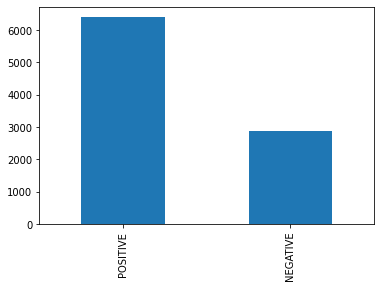

In [166]:
image_captions['hf_sent_class'].value_counts().plot(kind = 'bar')

In [167]:
image_captions['hf_sent_conf'].describe() 

count    9296.000000
mean        0.949773
std         0.098809
min         0.500172
25%         0.960185
50%         0.992917
75%         0.998538
max         0.999889
Name: hf_sent_conf, dtype: float64

Looks a bit more balanced using huggingface!

### Huggingface caption confidence thresholds

<AxesSubplot:ylabel='Frequency'>

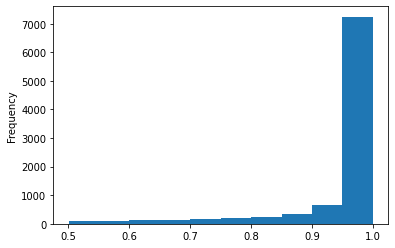

In [168]:


image_captions['hf_sent_conf'].plot.hist()

In [169]:
q = np.linspace(.1, 1, 9, 0)
image_captions['hf_sent_conf'].quantile(q)

0.1    0.829353
0.2    0.938639
0.3    0.972300
0.4    0.986294
0.5    0.992917
0.6    0.996111
0.7    0.997903
0.8    0.998998
0.9    0.999596
Name: hf_sent_conf, dtype: float64

As we can see, only 10% of the data has confidence under 80% - We are dealing with high confidence labels here!

As we can see, only 10% of the data has confidence under 80% - We are dealing with high confidence labels here!

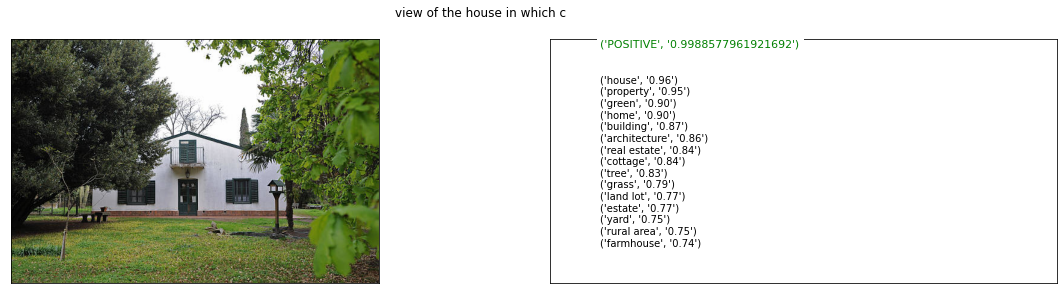

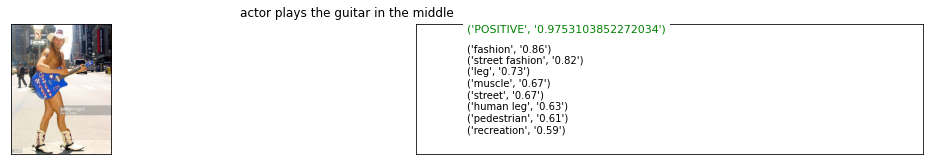

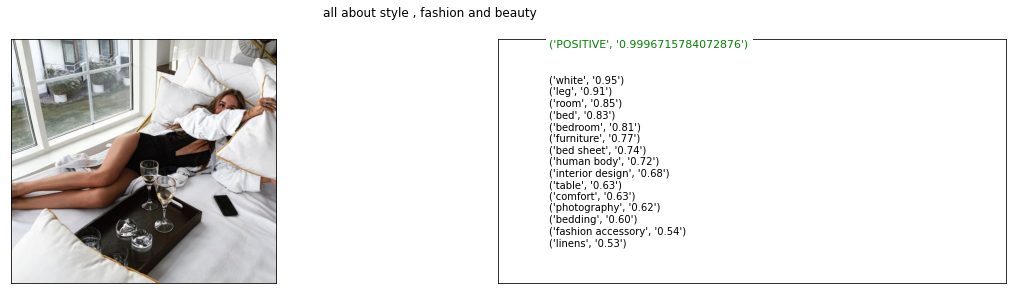

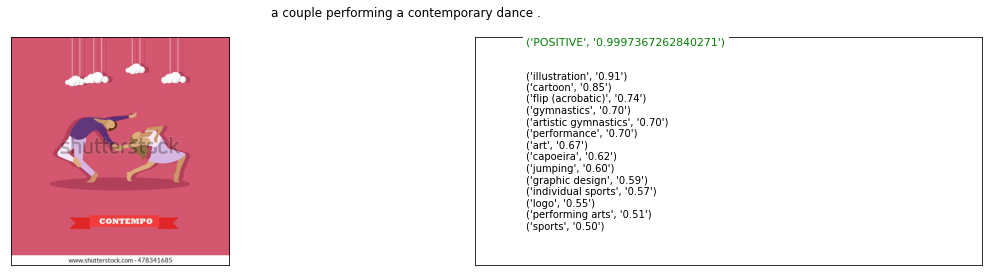

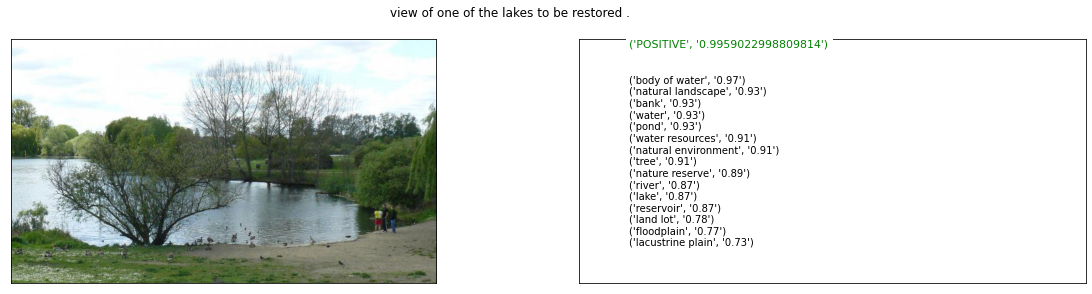

In [170]:
display_samples_with_hf_label(image_captions, "POSITIVE")


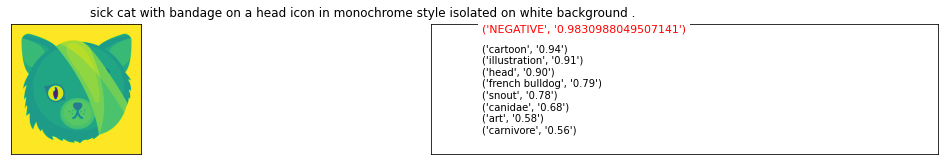

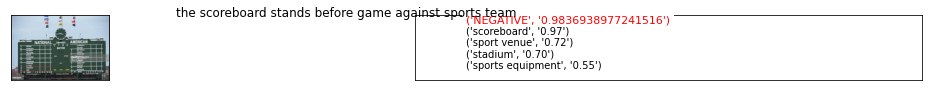

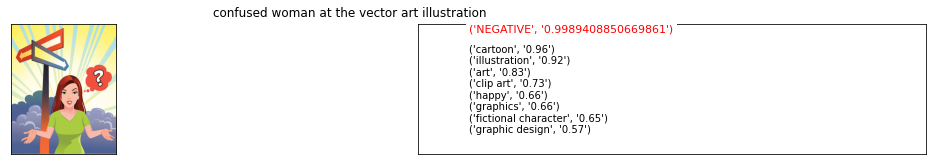

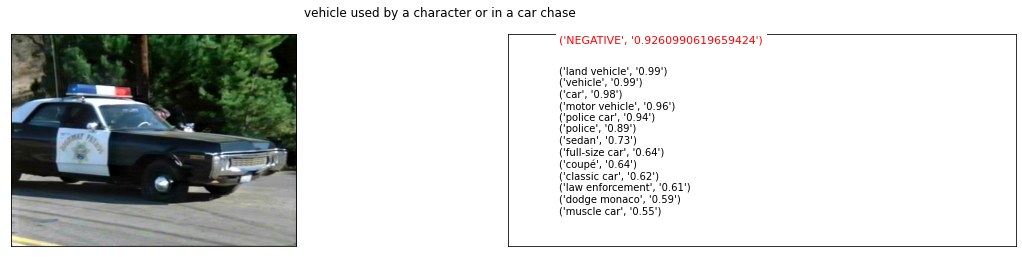

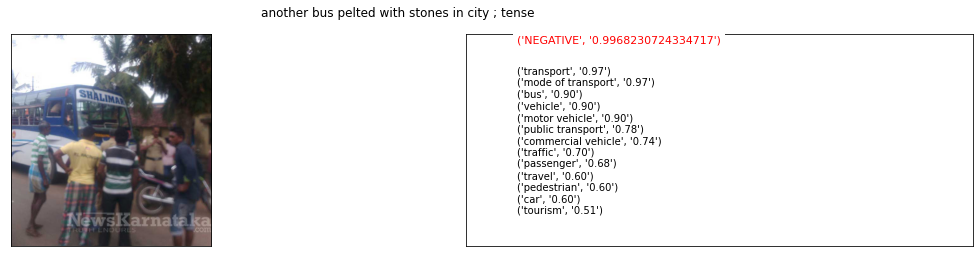

In [171]:
display_samples_with_hf_label(image_captions, "NEGATIVE")


In [174]:
print(image_captions.columns)

Index(['caption', 'link', 'objects', 'mid', 'object_confidences', 'image_path',
       'global_index', 'size', 'height', 'width', 'aspect_ratio', 'num_obj',
       'nltk_sent_polarity', 'nltk_sent', 'nltk_sent_pos_neg',
       'nltk_sent_pos_neg_conf', 'hf_sent', 'hf_sent_class', 'hf_sent_conf'],
      dtype='object')


In [173]:
##Lets save all this info to use in a later stage. Only if we are still preprocessing and want to save
if(process):
    data_path = os.path.join('data', data_dir)
    sent_path = os.path.join(data_path,'sent_added')
    #if(not os.exists(sent_path))
    image_captions.to_csv(sent_path,index=False)